# Advanced Machine Learning
# Final Project - Part \#1 - Anchor Paper Mission

<br>
by  
Segall Tomer, ID301833833   
Millis Sahar, ID300420379  

<br><br><br>

**Instructions**

The anchor paper mission has to be submitted as a PDF file, no longer than 3 PDF pages.

It should address the following points:

  - Relevant and related studies - mention the relevant studies you found so far. Shortly write about each of those papers (not more than one paragraph for each). State at least two relevant studies

  - Anchor paper implementation:
    - State the anchor paper.
    - Reference external code repositories that you have used so for (if any).
    - Summarize your coding effort so far - what was done, whether you faced technical challenges and why, gaps you still have.
    - Provide a link to your code repository (e.g., a Git repo) where you implemented the anchor paper algorithm.

  - Anchor paper results
    - Report the results you obtained out of your implementation and show a comparison to the reported results in the anchor paper
    - (optional) Report any additional results you got so far - based on another data set or another configuration you have tried

  - Comments 
    - Feel free to add relevant comments to your submission so we better understand the status of your research effort.

### Article's Code
You can find it in <a href='https://github.com/wuningxi/tBERT'>this</a> Github.


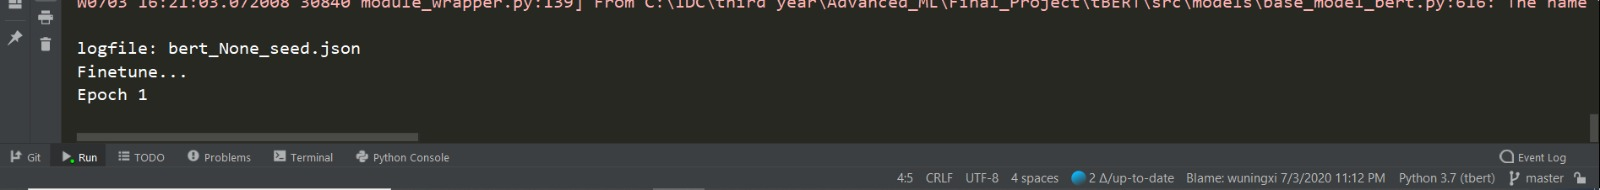

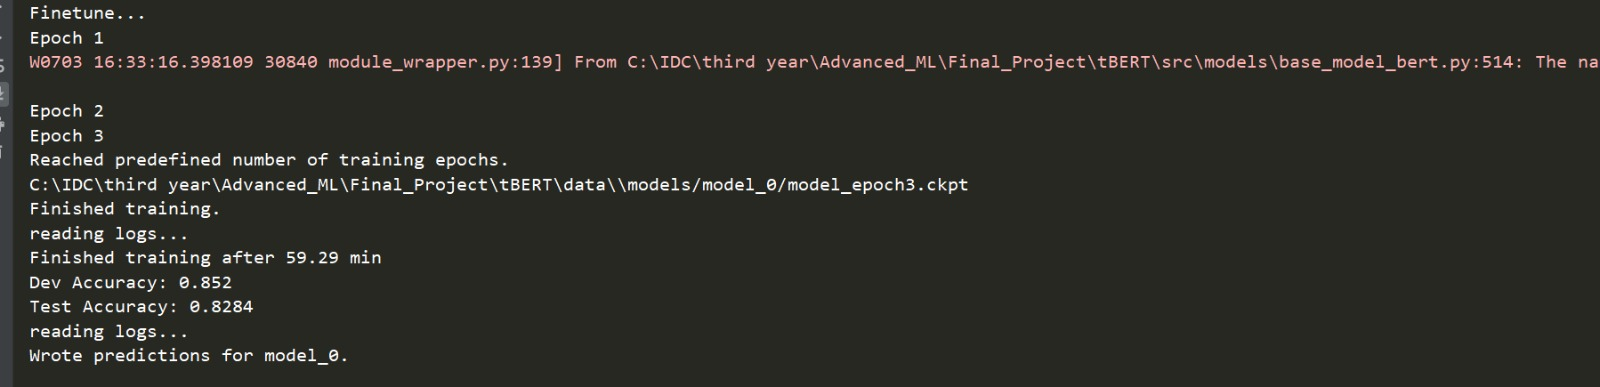

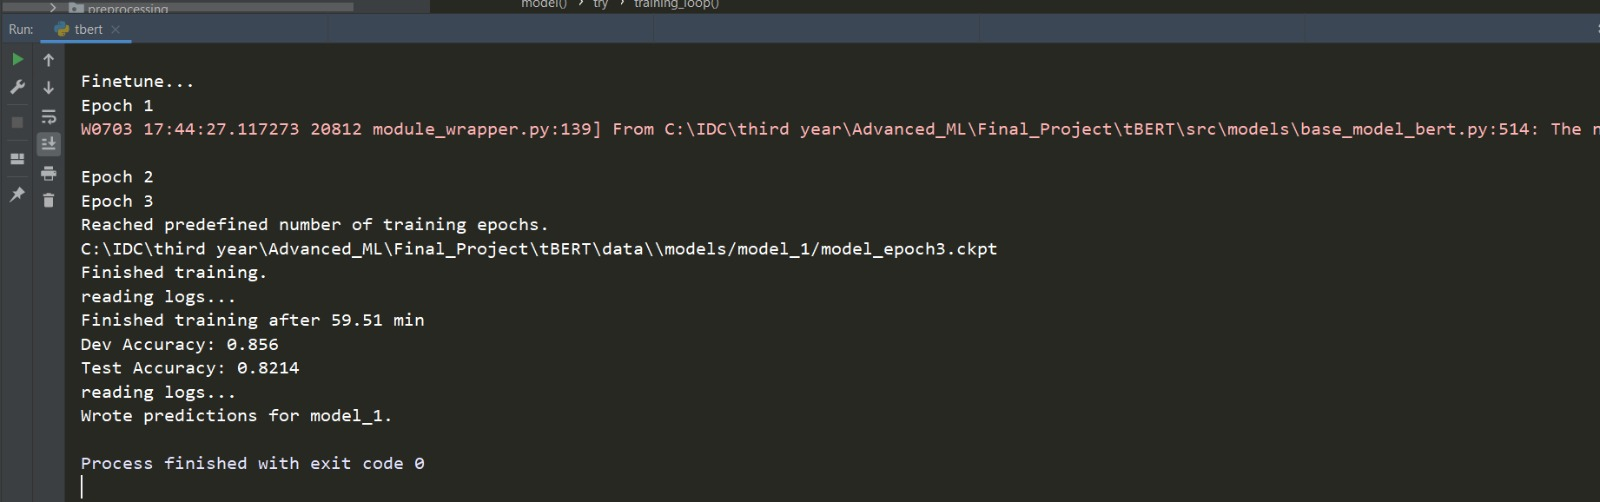

As you can see, although it's a hellish code, **we managed to run it**.  

But needed to make a better code version, while using pandas-numpy-torch platforms.

<br><br><br><br>




### Prerequisites:

In [1]:
!pip install --quiet transformers
!pip install --quiet nlpaug

     |████████████████████████████████| 2.8 MB 3.2 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 636 kB 60.5 MB/s 
     |████████████████████████████████| 895 kB 49.9 MB/s 
     |████████████████████████████████| 3.3 MB 33.9 MB/s 
     |████████████████████████████████| 405 kB 3.9 MB/s 


### Imports:

In [2]:
import gc
import random
import os.path
import warnings


import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS



import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize


import torch
from torch import nn
import torch.optim as optim
from torch.cuda import empty_cache
from torch.utils.data import DataLoader, random_split


from transformers import logging
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
from transformers import BertModel,BertTokenizer


from nlpaug.augmenter import word as naw
from nlpaug.augmenter import sentence as nas


from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,classification_report

from google.colab import auth
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

##### Warnings & Verbose

In [3]:
warnings.filterwarnings("ignore") # general
logging.set_verbosity_error() # huggingface

##### Setup -  Natural Language Tool Kit 

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

##### Setup - Google Drive

In [5]:
drive.mount('/content/drive',force_remount=True)
current_dir = 'drive/My Drive/Colab Notebooks/AdvancedML/Final_Project/' 

Mounted at /content/drive


In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)

def EMPTY_DRIVE_TRASH():
  my_drive = GoogleDrive(gauth)
  for a_file in my_drive.ListFile({'q': "trashed = true"}).GetList():
    a_file.Delete()


## Dataset

##### Torch's Dataset

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        x = self.encodings[idx]
        y = self.labels[idx]
        return x,y

    def __len__(self):
        return len(self.encodings)


class PairDataset(torch.utils.data.Dataset):
    def __init__(self, text1,text2,labels):
        self.text1  = text1
        self.text2  = text2
        self.labels = labels

    def __getitem__(self, idx):
        x1 = self.text1[idx]
        x2 = self.text2[idx]
        y = self.labels[idx]
        return x1,x2,y

    def __len__(self):
        return len(self.labels)

### MSRP


In [11]:
msrp_train = current_dir + 'data/MSRP/msr-para-train.tsv'
msrp_val   = current_dir + 'data/MSRP/msr-para-val.tsv'
msrp_test  = current_dir + 'data/MSRP/msr-para-test.tsv'

##### Create a dataframe

In [12]:
df_msrp_train = pd.read_csv(msrp_train, sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()
df_msrp_val   = pd.read_csv(msrp_val,   sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()
df_msrp_test  = pd.read_csv(msrp_test,  sep='\t', header=0, error_bad_lines=False, warn_bad_lines=False, names=['label','q1_id','q2_id','q1','q2'],usecols=[0,3,4]).dropna()

df_msrp_train.shape,df_msrp_val.shape,df_msrp_test.shape


((3461, 3), (480, 3), (1641, 3))

##### Create PairDataset

In [13]:
dataset_msrp_train = PairDataset(df_msrp_train.q1.values, df_msrp_train.q2.values, df_msrp_train.label.values)
dataset_msrp_val   = PairDataset(df_msrp_val.q1.values,   df_msrp_val.q2.values,   df_msrp_val.label.values)
dataset_msrp_test  = PairDataset(df_msrp_test.q1.values,  df_msrp_test.q2.values,  df_msrp_test.label.values)

##### Distribution - Traget Labels  


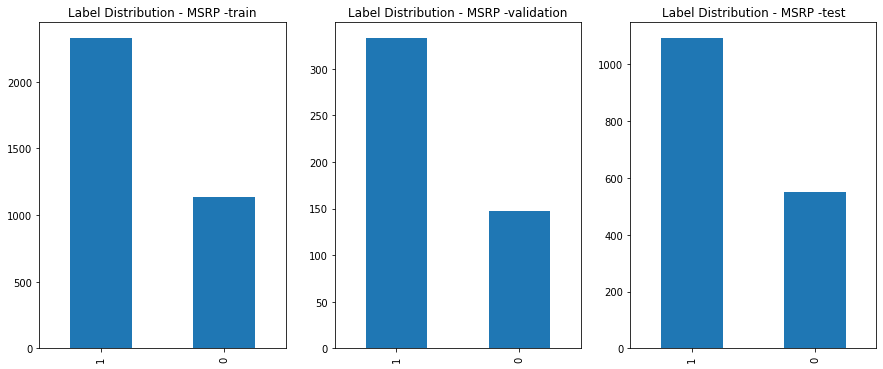

In [14]:
d = {'train':df_msrp_train,'validation':df_msrp_val,'test':df_msrp_test}

plt.figure(figsize=(15,6))

for i,(k,v) in enumerate(d.items()):
  plt.subplot(1,3,i+1)
  v.label.value_counts().plot.bar();
  plt.title('Label Distribution - MSRP -' + k)

Good. Datset has the same distribution.  
Sadly, there are twise as much "true" then "false" - we can try to fix that or use some form of class weights.
<br><br>

##### Wordcloud - words conceptual frequencies

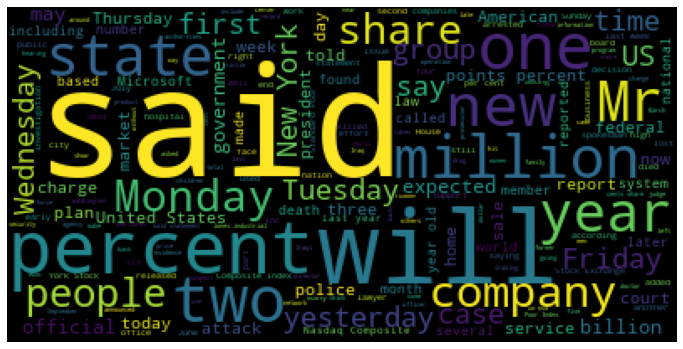

In [15]:
questions = df_msrp_train['q1'].tolist()
questions.extend(df_msrp_train['q2'].tolist())
questions = list(set(questions))
wordcloud = WordCloud(stopwords=STOPWORDS).generate(' '.join(questions))

# Generate plot
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Augmentation

More data we have, better performance we can achieve. However, it is very too luxury to annotate large amount of training data. Therefore, proper data augmentation is useful to boost up your model performance. 

In natural language processing (NLP) field, it is hard to augmenting text due to high complexity of language. Not every word we can replace it by others such as a, an, the.   
Also, not every word has synonym. Even changing a word, the context will be totally difference. 

We choose to use `nlpaug` library becuase it's lightweight, quick and easy-to-use.

Various known textual augmentation techniques:
- Thesaurus
- Word Embeddings
- Contextualized Word Embeddings
- Back Translation
- Text Generation

Based on our dataset we choose 3 different operations:
- Generate a summary of the sentence.
- Insert words base on contextual embeddings.
- Translation from English to German and back to English. (very slow)

In [16]:
AUG_FILE_NAME = current_dir+'data/df_msrp_train_aug.pkl'

def textual_augment(df_train,aug):
  df_train_aug = df_train.copy()

  q1 = df_train_aug.q1.tolist()
  q2 = df_train_aug.q2.tolist()

  df_train_aug.q1 = aug.augment(q1)
  df_train_aug.q2 = aug.augment(q2)

  return df_train_aug

def get_aug_df(df_train):
  global AUG_FILE_NAME

  aug_sum = nas.AbstSummAug(model_path='t5-base')
  aug_insert = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
  aug_translate = naw.BackTranslationAug(from_model_name='facebook/wmt19-en-de', to_model_name='facebook/wmt19-de-en')

  # takes about an 1-2 hours
  df_ = df_train.copy()  
  df_ = df_.append(textual_augment(df_train.head(1000),aug_sum))
  df_ = df_.append(textual_augment(df_train.tail(1000),aug_insert))
  df_ = df_.append(textual_augment(df_train.head(2000).tail(1000),aug_translate))
  df_.to_pickle(AUG_FILE_NAME)

# if not exists create augmented df
if not os.path.exists(AUG_FILE_NAME):
  get_aug_df(df_msrp_train)

# augmented dataframe
df_msrp_train_aug = pd.read_pickle(AUG_FILE_NAME)
df_msrp_train_aug = df_msrp_train.append(df_msrp_train_aug)

# augmented dataset
dataset_msrp_train_aug = PairDataset(df_msrp_train_aug.q1.values, df_msrp_train_aug.q2.values, df_msrp_train_aug.label.values)

df_msrp_train_aug.shape,df_msrp_val.shape,df_msrp_test.shape

((9822, 3), (480, 3), (1641, 3))

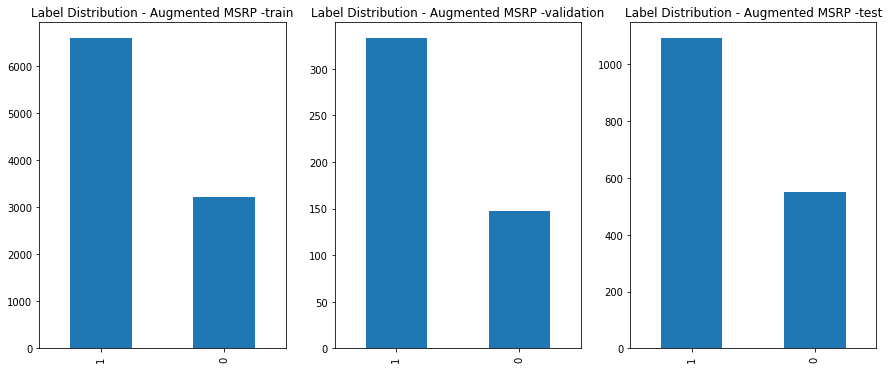

In [17]:
d = {'train':df_msrp_train_aug,'validation':df_msrp_val,'test':df_msrp_test}

plt.figure(figsize=(15,6))

for i,(k,v) in enumerate(d.items()):
  plt.subplot(1,3,i+1)
  v.label.value_counts().plot.bar();
  plt.title('Label Distribution - Augmented MSRP -' + k)

<br><br><br><br>

### Fake News

##### Create a dataframe

In [18]:
fake_news = current_dir + 'data/fake_news.csv'

df_fakenews = pd.read_csv(fake_news, index_col=0)
df_fakenews['label_binary'] = df_fakenews["label"].map({"REAL": 0, "FAKE": 1}).values.astype('float')

fakenews_column = 'title'
df_fakenews_train, df_fakenews_valid, df_fakenews_test = np.split(df_fakenews[[fakenews_column,'label_binary']].sample(frac=1), [int(.6*len(df_fakenews)), int(.8*len(df_fakenews))])

df_fakenews_train.shape,df_fakenews_valid.shape,df_fakenews_test.shape

((3801, 2), (1267, 2), (1267, 2))

##### Create Dataset

In [19]:
dataset_fakenews_train = Dataset(df_fakenews_train.iloc[:,0].values, df_fakenews_train.iloc[:,1].values)
dataset_fakenews_val   = Dataset(df_fakenews_valid.iloc[:,0].values, df_fakenews_valid.iloc[:,1].values)
dataset_fakenews_test  = Dataset(df_fakenews_test.iloc[:,0].values, df_fakenews_test.iloc[:,1].values)

##### Distribution - Traget Labels  


''

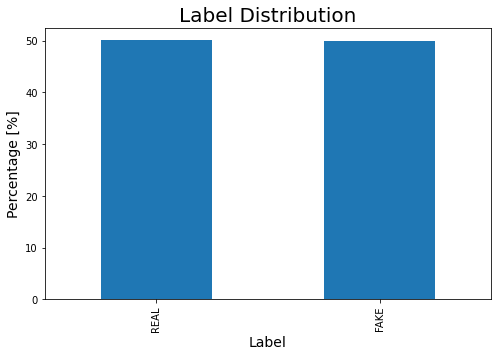

In [20]:
plt.figure(figsize=(8,5))

(round(df_fakenews["label"].value_counts() / df_fakenews.shape[0] * 100, 2)).plot(kind="bar")
plt.title("Label Distribution", fontsize=20)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Percentage [%]", fontsize=14)
;

##### Wordcloud - words conceptual frequencies

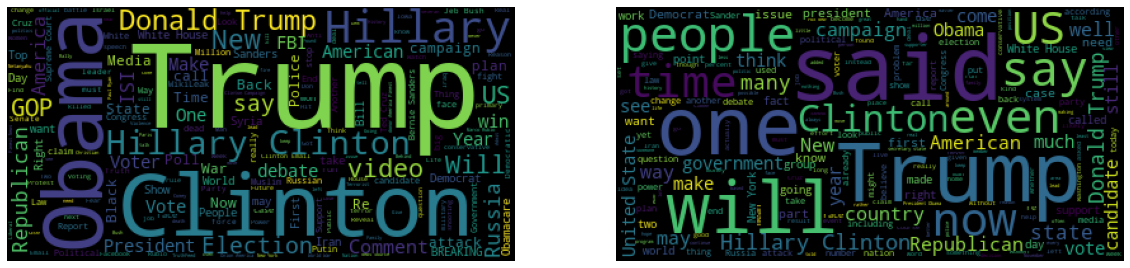

In [21]:
titles = df_fakenews.title.tolist()
texts = df_fakenews.text.tolist()

wordcloud_titles = WordCloud(stopwords=STOPWORDS).generate(' '.join(titles))
wordcloud_texts = WordCloud(stopwords=STOPWORDS).generate(' '.join(texts))

# Generate plot
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_titles)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wordcloud_texts)
plt.axis("off")
plt.show()

##### Augmentation

In [22]:
AUG_FILE_NAME_SUM = current_dir + 'data/df_fake_news_train_aug_sum.pkl'
AUG_FILE_NAME_INSERT = current_dir + 'data/df_fake_news_train_aug_insert.pkl'

def textual_augment(df_train,col,aug):
  df_train_aug = df_train.copy()
  lst = df_train[col].tolist()
  df_train_aug[col] = aug.augment(lst)
  return df_train_aug

if not os.path.exists(AUG_FILE_NAME_SUM): 
  aug_sum = nas.AbstSummAug(model_path='t5-base')
  ta = textual_augment(df_fakenews_train,fakenews_column,aug_sum)
  ta.to_pickle(AUG_FILE_NAME_SUM)
  aug_sum = None

if not os.path.exists(AUG_FILE_NAME_INSERT): 
  aug_insert = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
  ta = textual_augment(df_fakenews_train,fakenews_column,aug_insert)
  ta.to_pickle(AUG_FILE_NAME_INSERT)
  aug_insert = None

# read df
df_fakenews_train_aug_sum    = pd.read_pickle(AUG_FILE_NAME_SUM)
df_fakenews_train_aug_insert = pd.read_pickle(AUG_FILE_NAME_INSERT)

# prepare
df_temp_sum    = df_fakenews_train.append(df_fakenews_train_aug_sum)
df_temp_insert = df_fakenews_train.append(df_fakenews_train_aug_insert)

# torch dataset
dataset_fakenews_train_aug_sum    = Dataset(df_temp_sum.iloc[:,0].values, df_temp_sum.iloc[:,1].values)
dataset_fakenews_train_aug_insert = Dataset(df_temp_insert.iloc[:,0].values, df_temp_insert.iloc[:,1].values)

df_fakenews_train.shape, df_fakenews_train_aug_sum.shape, df_fakenews_train_aug_insert.shape

((3801, 2), (3801, 2), (3801, 2))

## Models - Setup DL models

#### Model - BERT

In [23]:
class model_BERT(nn.Module):
    def __init__(self,n_components=10,n_classes=1,model_name="bert-base-uncased",max_len=20,batch_size=64):
        super(model_BERT, self).__init__()

        self.batch_size = batch_size
        self.max_len = max_len

        self.tokenizer_bert = BertTokenizer.from_pretrained(model_name)
        self.model_bert = BertModel.from_pretrained(model_name)

        self.classifier = nn.Sequential(
            nn.Linear(768, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, n_classes, bias=True),            
            nn.Sigmoid()
        )


    def tokenizing(self,sentences):
      return self.tokenizer_bert.batch_encode_plus(sentences,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def tokenizing_pair(self,sentences1,sentences2):
      return self.tokenizer_bert(sentences1,sentences2,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def forward(self, tokens_bert):

        # features
        features_bert = self.model_bert(tokens_bert).last_hidden_state[:, 0, :]

        # classification
        outputs = self.classifier(features_bert)
        return outputs 

#### Model - tBERT

In [24]:
class model_tBERT(nn.Module):
    def __init__(self,n_components=10,n_classes=1,model_name="bert-base-uncased",max_len=50,batch_size=64,sentences=[''],isPair=0):
        super(model_tBERT, self).__init__()

        self.batch_size = batch_size
        self.max_len = max_len

        self.tokenizer_bert = BertTokenizer.from_pretrained(model_name)
        self.model_bert = BertModel.from_pretrained(model_name)
        
        self.model_lda = LDA(n_components=n_components,batch_size=batch_size,n_jobs=-1)
        self.sentences = [self.preprocessing(sentence) for sentence in sentences]
        
        self.sentences = self.tokenizing(self.sentences) # self.tokenizer_bert.batch_encode_plus(self.sentences,return_tensors='pt',padding=True,max_length=max_len, pad_to_max_length=True)['input_ids'][:,1:-1]
        self.model_lda.fit(self.sentences)

        self.classifier = nn.Sequential(
            nn.Linear(768 + n_components + isPair*n_components, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, n_classes, bias=True),
            nn.Sigmoid()
        )

    def preprocessing(self,sentence):
      sentence = str(sentence).lower()                                            # lower latters
      words = word_tokenize(sentence)                                             # split into words
      words = [word for word in words if word.isalpha()]                          # remove punctuations
      words = [word for word in words if word not in stopwords.words('english')]  # remove stopwords
      words = [word for (word, pos) in nltk.pos_tag(words) if pos[:2] == 'NN']    # keep nouns
      sentence = ' '.join(words)                                                  # combine words to a sentence
      return sentence

    def tokenizing(self,sentences):
      return self.tokenizer_bert.batch_encode_plus(sentences,return_tensors='pt',add_special_tokens=False,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def tokenizing_pair(self,sentences1,sentences2):
      return self.tokenizer_bert(sentences1,sentences2,return_tensors='pt',add_special_tokens=True,padding="max_length",max_length=self.max_len, pad_to_max_length=True,truncation=True)['input_ids']

    def freeze_BERT(self,):
      for param in self.model_bert.parameters():
        param.requires_grad = False

    def forward(self, tokens_bert,features_lda):

        # features
        features_bert = self.model_bert(tokens_bert).last_hidden_state[:, 0, :]

        # concatenate
        features = torch.cat([features_lda, features_bert],dim=1)
        self.aa = features
        self.bb = features_bert
        
        # classification
        outputs = self.classifier(features)
        return outputs 

#### Setup Trainer

In [25]:
class myTrainer():
  def __init__(self,
               model,
               train_dataset, val_dataset,test_dataset,
               epochs = 5, with_LDA = True, model_name = 'basemodel',current_dir = current_dir,lr=0.001
               ):
    
    self.model = model
    self.epochs = epochs
    self.with_LDA = with_LDA
    self.model_name = str(model_name)
    self.current_dir = current_dir
    
    self.criterion = nn.BCELoss()
    self.optimizer = optim.Adam(self.model.parameters(),lr=lr)
    self.train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    self.val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    self.test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    self.loss_train = []
    self.loss_val = []


  def train(self):
    min_valid_loss = np.inf
    
    # run on all epochs
    print(self.model_name + ': Training \t',end='')
    for e in range(self.epochs):
      # print()

      # train
      for data in self.train_dataloader:
        print('.',end='')

        if len(data)==3:
          self.train_loss_pair(data)
        else:
          self.train_loss(data)

      # eval      
      self.model.eval()     # Optional when not using Model Specific layer
      for data in self.val_dataloader:
        if len(data)==3:
          self.val_loss_pair(data)
        else:
          self.val_loss(data)
      
      # print progress
      # print(f'Epoch {e+1} \t\t Training Loss: {self.loss_train[-1] / len(self.train_dataloader)} \t\t Validation Loss: {self.loss_val[-1] / len(self.val_dataloader)}')

      # save the optimal model    
      if min_valid_loss > self.loss_val[-1]:
          # print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{self.loss_val[-1]:.6f})')
          min_valid_loss = self.loss_val[-1]
          self.save_model()

    # load best model
    self.load_model()   
    self.delete_saved_files() 
  

  def train_loss(self,data):
    inputs, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs)  #.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      tokens_lda = self.model.tokenizing(inputs)
      features_lda = self.model.model_lda.transform(tokens_lda)
      features_lda = torch.tensor(features_lda).type(torch.FloatTensor)
      features_lda = features_lda.cuda()

      self.a = tokens_bert
      self.b = tokens_lda
      self.c = features_lda

      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
      
    # Find the Loss
    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()
    loss = self.criterion(target,labels)

    # Calculate gradients 
    loss.backward()

    # Update Weights
    self.optimizer.step()

    # Calculate Loss
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def train_loss_pair(self,data):
    inputs1, inputs2, labels = data

    # Clear the gradients
    self.optimizer.zero_grad()

    # tokenizer
    tokens_bert = self.model.tokenizing_pair(inputs1,inputs2)
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      # inputs1
      tokens_lda1 = self.model.tokenizing(inputs1)
      features_lda1 = self.model.model_lda.transform(tokens_lda1)
      features_lda1 = torch.tensor(features_lda1).type(torch.FloatTensor)
      
      # inputs2
      tokens_lda2 = self.model.tokenizing(inputs2)
      features_lda2 = self.model.model_lda.transform(tokens_lda2)
      features_lda2 = torch.tensor(features_lda2).type(torch.FloatTensor)
      
      features_lda = torch.cat([features_lda1, features_lda2],dim=1)
      features_lda = features_lda.cuda()
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
      
    # Find the Loss
    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()
    loss = self.criterion(target,labels)

    # Calculate gradients 
    loss.backward()

    # Update Weights
    self.optimizer.step()

    # Calculate Loss
    train_loss = loss.item() * len(data)
    self.loss_train.append(train_loss)


  def val_loss(self,data):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()

    # tokenizer
    tokens_bert = self.model.tokenizing(inputs) #self.model.tokenizer_bert.batch_encode_plus(inputs,return_tensors='pt',padding=True)['input_ids']
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      tokens_lda = self.model.tokenizing(inputs)
      features_lda = self.model.model_lda.transform(tokens_lda)
      features_lda = torch.tensor(features_lda).type(torch.FloatTensor)
      features_lda = features_lda.cuda()      
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
    
    # Find the Loss
    loss = self.criterion(target,labels)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def val_loss_pair(self,data):
    # get the inputs; data is a list of [inputs, labels]
    inputs1, inputs2, labels = data

    labels = labels.type(torch.FloatTensor).unsqueeze(1).cuda()

    # tokenizer
    tokens_bert = self.model.tokenizing_pair(inputs1,inputs2) 
    tokens_bert = tokens_bert.cuda()

    # LDA
    if self.with_LDA:
      # inputs1
      tokens_lda1 = self.model.tokenizing(inputs1)
      features_lda1 = self.model.model_lda.transform(tokens_lda1)
      features_lda1 = torch.tensor(features_lda1).type(torch.FloatTensor)
      
      # inputs2
      tokens_lda2 = self.model.tokenizing(inputs2)
      features_lda2 = self.model.model_lda.transform(tokens_lda2)
      features_lda2 = torch.tensor(features_lda2).type(torch.FloatTensor)
      
      features_lda = torch.cat([features_lda1, features_lda2],dim=1)
      features_lda = features_lda.cuda()
      target = self.model(tokens_bert,features_lda)
    else:
      target = self.model(tokens_bert)
    
    # Find the Loss
    loss = self.criterion(target,labels)

    # Calculate Loss
    valid_loss = loss.item() * len(data)
    self.loss_val.append(valid_loss)


  def predict(self):

    # results
    real_labels = []
    predictions = []

    self.model.eval()  
    with torch.no_grad():
      for data in self.test_dataloader:

        inputs, labels = data

        # tokenizer
        tokens_bert = self.model.tokenizing(inputs)
        tokens_bert = tokens_bert.cuda()
        
        # LDA
        if self.with_LDA:
          tokens_lda = self.model.tokenizing(inputs)
          features_lda = self.model.model_lda.transform(tokens_lda)
          features_lda = torch.tensor(features_lda).type(torch.FloatTensor)
          features_lda = features_lda.cuda()
          target = self.model(tokens_bert,features_lda)  
        else:
          target = self.model(tokens_bert)

    target = target.round()
    predictions.extend(target.cpu().detach()[:,0].tolist())
    real_labels.extend(labels.tolist())
    return real_labels,predictions


  def predict_pair(self):

    # results
    real_labels = []
    predictions = []

    self.model.eval() 
    with torch.no_grad():
      for data in self.test_dataloader:

        inputs1, inputs2, labels = data

        # tokenizer
        tokens_bert = self.model.tokenizing_pair(inputs1,inputs2)
        tokens_bert = tokens_bert.cuda()
        
        # LDA
        if self.with_LDA:
          tokens_lda1 = self.model.tokenizing(inputs1)
          features_lda1 = self.model.model_lda.transform(tokens_lda1)
          features_lda1 = torch.tensor(features_lda1).type(torch.FloatTensor)
          
          tokens_lda2 = self.model.tokenizing(inputs2)
          features_lda2 = self.model.model_lda.transform(tokens_lda2)
          features_lda2 = torch.tensor(features_lda2).type(torch.FloatTensor)
          
          features_lda = torch.cat([features_lda1, features_lda2],dim=1)
          features_lda = features_lda.cuda()
          target = self.model(tokens_bert,features_lda)  
        else:
          target = self.model(tokens_bert)

    target = target.round()
    predictions.extend(target.cpu().detach()[:,0].tolist())
    real_labels.extend(labels.tolist())
    return real_labels,predictions


  def save_model(self):
    # print('Saving the model... ',end='')
    with open(self.current_dir + 'results/'+ self.model_name +'.pkl', 'wb') as f:
      pickle.dump(self.model, f, pickle.HIGHEST_PROTOCOL)
    # print('done!')


  def load_model(self):
    # print('Loading the model... ',end='')
    with open(self.current_dir + 'results/'+ self.model_name +'.pkl', 'rb') as f:
      self.model = pickle.load(f)
    print('done!')


  def delete_saved_files(self):
    for f in os.listdir(current_dir+'/results'):
      os.remove(current_dir+'/results/' + f)
    EMPTY_DRIVE_TRASH()


  def plot_losses(self):
    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plt.plot(self.loss_train)
    plt.title('Train Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss')

    plt.subplot(1,2,2)
    plt.plot(self.loss_val)
    plt.title('Validation Loss')
    plt.xlabel('# batch')
    plt.ylabel('loss');
    

In [26]:
def add_result(df_,topics, real_tbert, pred_tbert, loss_train, loss_val):
  accuracy_tbert = accuracy_score(y_true=real_tbert,y_pred=pred_tbert)
  df_.loc[len(df_)] = [str(topics),accuracy_tbert,loss_train,loss_val]

## Train Models - MSRP

##### Train tBERT - with search over number of topics

In [24]:
random.seed(123)

df = pd.DataFrame(columns=['TopicsNumber','tBERT_Accuracy','Loss_Train','Loss_Val'])

n_topics = [1,5,10,20,40,70,75,80,85,90]
all_sentences = df_msrp_train.q1.values.tolist()
all_sentences.extend(df_msrp_train.q2.values.tolist())
all_sentences = list(set(all_sentences))  

for n in n_topics:

  # model
  model_tbert = model_tBERT(sentences=all_sentences,isPair=1,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # ORIGINAL
  # train
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_msrp_t'+str(n),train_dataset=dataset_msrp_train,val_dataset=dataset_msrp_val,test_dataset=dataset_msrp_test,epochs=3)
  trainer_tBERT.train()

  # predict
  real_tbert_msrp,pred_tbert_msrp = trainer_tBERT.predict_pair()

  # save model results
  add_result(df,n, real_tbert_msrp, pred_tbert_msrp,trainer_tBERT.loss_train,trainer_tBERT.loss_val)

  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

tbert_msrp_t1: Training 	.....................................................................................................................................................................done!
tbert_msrp_t5: Training 	.....................................................................................................................................................................done!
tbert_msrp_t10: Training 	.....................................................................................................................................................................done!
tbert_msrp_t20: Training 	.....................................................................................................................................................................done!
tbert_msrp_t40: Training 	.....................................................................................................................................................................done!
tbert_msrp_t70: T

##### Train tBERT - on augmented data


In [25]:
random.seed(123)

df_aug = pd.DataFrame(columns=['TopicsNumber','tBERT_Accuracy','Loss_Train','Loss_Val'])

n_topics = [1,5,10,20,40,70,75,80,85,90]
all_sentences = df_msrp_train_aug.q1.values.tolist()
all_sentences.extend(df_msrp_train_aug.q2.values.tolist())
all_sentences = list(set(all_sentences))  

for n in n_topics:

  # model
  model_tbert = model_tBERT(sentences=all_sentences,isPair=1,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # train - on augmented data
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_msrp_aug_t'+str(n),train_dataset=dataset_msrp_train_aug,val_dataset=dataset_msrp_val,test_dataset=dataset_msrp_test,epochs=1)
  trainer_tBERT.train()

  # predict
  real_tbert_msrp,pred_tbert_msrp = trainer_tBERT.predict_pair()

  # save model results
  add_result(df_aug,n, real_tbert_msrp, pred_tbert_msrp,trainer_tBERT.loss_train,trainer_tBERT.loss_val)

  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

tbert_msrp_aug_t1: Training 	..........................................................................................................................................................done!
tbert_msrp_aug_t5: Training 	..........................................................................................................................................................done!
tbert_msrp_aug_t10: Training 	..........................................................................................................................................................done!
tbert_msrp_aug_t20: Training 	..........................................................................................................................................................done!
tbert_msrp_aug_t40: Training 	..........................................................................................................................................................done!
tbert_msrp_aug_t70: Training 	......................

### Evaluation

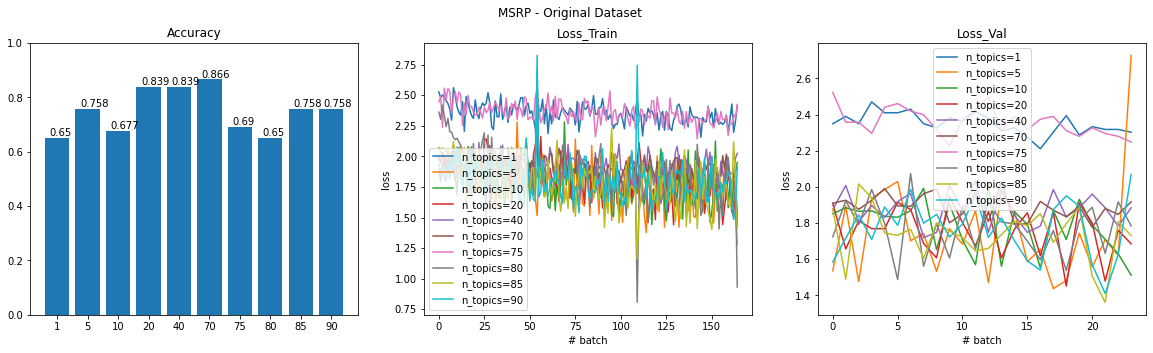

In [160]:
plt.figure(figsize=(20,5)).suptitle('MSRP - Original Dataset')

plt.subplot(1,3,1)
plt.bar(df.TopicsNumber,df.tBERT_Accuracy)
for index,data in enumerate(df.tBERT_Accuracy):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.title('Accuracy')
plt.ylim([0, 1])

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df)):
    y = df[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

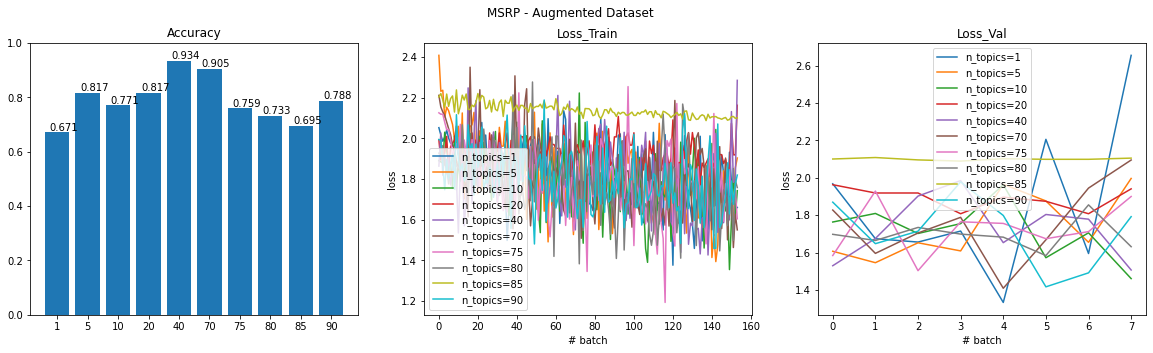

In [162]:
plt.figure(figsize=(20,5)).suptitle('MSRP - Augmented Dataset')

plt.subplot(1,3,1)
plt.bar(df_aug.TopicsNumber,df_aug.tBERT_Accuracy)
for index,data in enumerate(df_aug.tBERT_Accuracy):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.title('Accuracy')
plt.ylim([0, 1])

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df_aug)):
    y = df_aug[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df_aug.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

A couple of models performing well or better then the one in the article.  
While creating a better version of code.

## Train Models - Fake News

### Train tBERT - Search over topic's number 

In [33]:
random.seed(123)

df_fake = pd.DataFrame(columns=['TopicsNumber','tBERT_Accuracy','Loss_Train','Loss_Val'])

n_topics = [1,5,10,20,40,70,75,80,85,90]
all_sentences = df_fakenews_train[fakenews_column].values.tolist()
all_sentences = list(set(all_sentences))  

for n in n_topics:

  # model
  model_tbert = model_tBERT(sentences=all_sentences,isPair=0,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # train
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_fake_news_t'+str(n),train_dataset=dataset_fakenews_train,val_dataset=dataset_fakenews_val,test_dataset=dataset_fakenews_test,epochs=4)
  trainer_tBERT.train()

  # predict
  real,pred = trainer_tBERT.predict()

  # save model results
  add_result(df_fake,n, real, pred,trainer_tBERT.loss_train,trainer_tBERT.loss_val)

  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

tbert_fake_news_t1: Training 	................................................................................................................................................................................................................................................done!
tbert_fake_news_t5: Training 	................................................................................................................................................................................................................................................done!
tbert_fake_news_t10: Training 	................................................................................................................................................................................................................................................done!
tbert_fake_news_t20: Training 	............................................................................................................................................

### Train tBERT - with Augmented Data

In [34]:
random.seed(123)

df_fake_aug_sum = pd.DataFrame(columns=['TopicsNumber','tBERT_Accuracy','Loss_Train','Loss_Val'])

n_topics = [1,5,10,20,40,70,75,80,85,90]
all_sentences = df_fakenews_train_aug_sum[fakenews_column].values.tolist()
all_sentences = list(set(all_sentences))  

for n in n_topics:

  # model
  model_tbert = model_tBERT(sentences=all_sentences,isPair=0,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # train
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_fake_news_aug_sum_t'+str(n),train_dataset=dataset_fakenews_train_aug_sum,val_dataset=dataset_fakenews_val,test_dataset=dataset_fakenews_test,epochs=2)
  trainer_tBERT.train()

  # predict
  real,pred = trainer_tBERT.predict()

  # save model results
  add_result(df_fake_aug_sum,n, real, pred,trainer_tBERT.loss_train,trainer_tBERT.loss_val)

  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

tbert_fake_news_aug_sum_t1: Training 	..............................................................................................................................................................................................................................................done!
tbert_fake_news_aug_sum_t5: Training 	..............................................................................................................................................................................................................................................done!
tbert_fake_news_aug_sum_t10: Training 	..............................................................................................................................................................................................................................................done!
tbert_fake_news_aug_sum_t20: Training 	..................................................................................................................

In [35]:
random.seed(123)

df_fake_aug_insert = pd.DataFrame(columns=['TopicsNumber','tBERT_Accuracy','Loss_Train','Loss_Val'])

n_topics = [1,5,10,20,40,70,75,80,85,90]
all_sentences = df_fakenews_train_aug_insert[fakenews_column].values.tolist()
all_sentences = list(set(all_sentences))  

for n in n_topics:

  # model
  model_tbert = model_tBERT(sentences=all_sentences,isPair=0,n_components=n).cuda();
  model_tbert.freeze_BERT()

  # train
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name='tbert_fake_news_aug_insert_t'+str(n),train_dataset=dataset_fakenews_train_aug_insert,val_dataset=dataset_fakenews_val,test_dataset=dataset_fakenews_test,epochs=2)
  trainer_tBERT.train()

  # predict
  real,pred = trainer_tBERT.predict()

  # save model results
  add_result(df_fake_aug_insert,n, real, pred,trainer_tBERT.loss_train,trainer_tBERT.loss_val)

  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

tbert_fake_news_aug_insert_t1: Training 	..............................................................................................................................................................................................................................................done!
tbert_fake_news_aug_insert_t5: Training 	..............................................................................................................................................................................................................................................done!
tbert_fake_news_aug_insert_t10: Training 	..............................................................................................................................................................................................................................................done!
tbert_fake_news_aug_insert_t20: Training 	......................................................................................................

### Evaluation

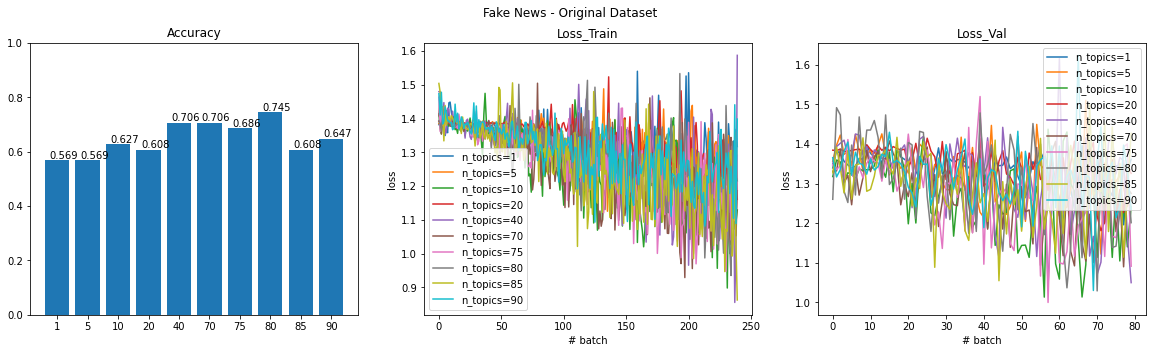

In [120]:
plt.figure(figsize=(20,5)).suptitle('Fake News - Original Dataset')

plt.subplot(1,3,1)
plt.bar(df_fake.TopicsNumber,df_fake.tBERT_Accuracy)
for index,data in enumerate(df_fake.tBERT_Accuracy):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.title('Accuracy')
plt.ylim([0, 1])

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df_fake)):
    y = df_fake[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df_fake.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

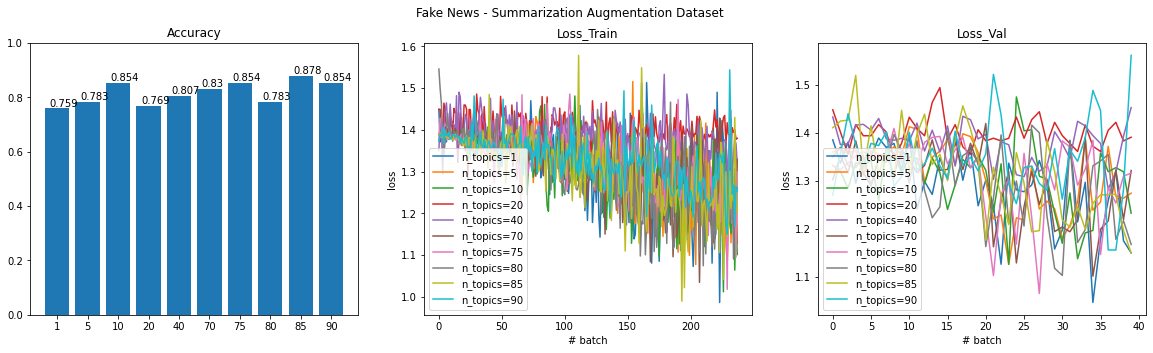

In [119]:
plt.figure(figsize=(20,5)).suptitle('Fake News - Summarization Augmentation Dataset')

plt.subplot(1,3,1)
plt.bar(df_fake_aug_sum.TopicsNumber,df_fake_aug_sum.tBERT_Accuracy)
for index,data in enumerate(df_fake_aug_sum.tBERT_Accuracy):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.title('Accuracy')
plt.ylim([0, 1])

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df_fake_aug_sum)):
    y = df_fake_aug_sum[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df_fake_aug_sum.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

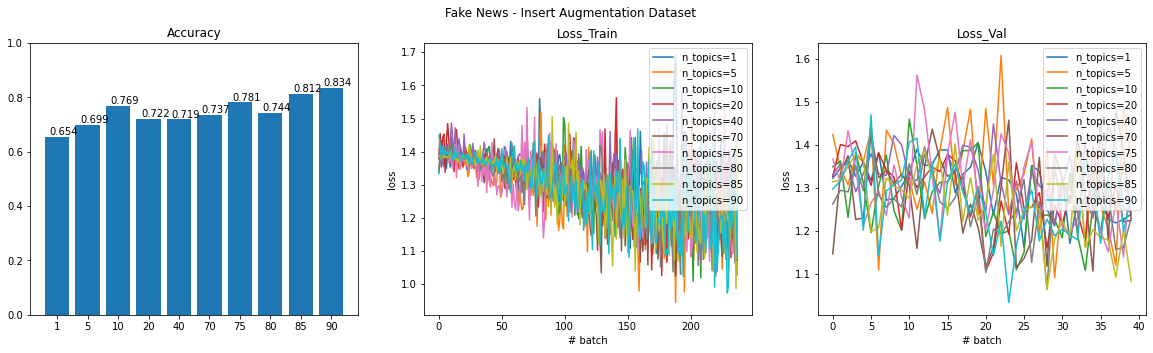

In [118]:
plt.figure(figsize=(20,5)).suptitle('Fake News - Insert Augmentation Dataset')

plt.subplot(1,3,1)
plt.bar(df_fake_aug_insert.TopicsNumber,df_fake_aug_insert.tBERT_Accuracy)
for index,data in enumerate(df_fake_aug_insert.tBERT_Accuracy):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.title('Accuracy')
plt.ylim([0, 1])

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df_fake_aug_insert)):
    y = df_fake_aug_insert[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df_fake_aug_insert.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

## Train Model - BERT versions

In [28]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
my_drive = GoogleDrive(gauth)


random.seed(123)

df_versions = pd.DataFrame(columns=['TopicsNumber','tBERT_Accuracy','Loss_Train','Loss_Val'])

n = 70
m_names = ['bert-base-uncased','bert-base-cased-finetuned-mrpc','distilbert-base-uncased','distilbert-base-uncased-distilled-squad','squeezebert/squeezebert-uncased']
all_sentences = df_msrp_train.q1.values.tolist()
all_sentences.extend(df_msrp_train.q2.values.tolist())
all_sentences = list(set(all_sentences))  

for m_name in m_names:

  # model
  model_tbert = model_tBERT(sentences=all_sentences,isPair=1,n_components=n,model_name=m_name).cuda();
  model_tbert.freeze_BERT()

  # ORIGINAL
  # train
  m_name = m_name.split('/')[-1]
  # print(m_name, sum(p.numel() for p in model_tbert.model_bert.parameters() ) )
  trainer_tBERT = myTrainer(model_tbert,with_LDA=True,model_name=m_name+'_t'+str(n),train_dataset=dataset_msrp_train,val_dataset=dataset_msrp_val,test_dataset=dataset_msrp_test,epochs=3)
  trainer_tBERT.train()

  # predict
  real_tbert_msrp,pred_tbert_msrp = trainer_tBERT.predict_pair()

  # save model results
  add_result(df_versions,m_name, real_tbert_msrp, pred_tbert_msrp,trainer_tBERT.loss_train,trainer_tBERT.loss_val)

  # free cuda
  model_tbert, trainer_tBERT = None, None
  gc.collect()
  empty_cache()

bert-base-uncased_t70: Training 	.....................................................................................................................................................................done!
bert-base-cased-finetuned-mrpc_t70: Training 	.....................................................................................................................................................................done!


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

distilbert-base-uncased_t70: Training 	.....................................................................................................................................................................done!


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/451 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

distilbert-base-uncased-distilled-squad_t70: Training 	.....................................................................................................................................................................done!


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/103M [00:00<?, ?B/s]

squeezebert-uncased_t70: Training 	.....................................................................................................................................................................done!


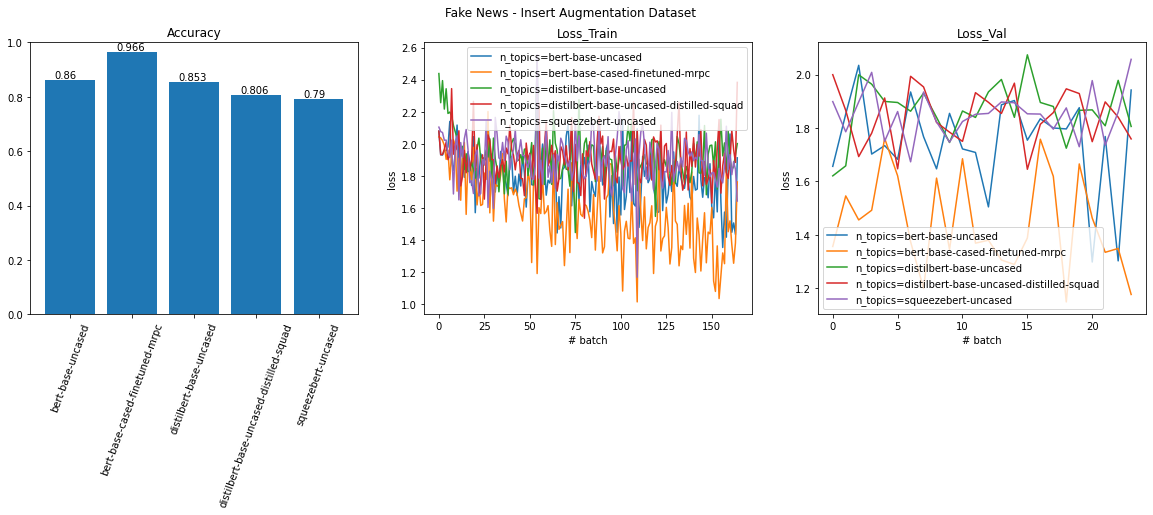

In [55]:
plt.figure(figsize=(20,5)).suptitle('Fake News - Insert Augmentation Dataset')

plt.subplot(1,3,1)
plt.bar(df_versions.TopicsNumber,df_versions.tBERT_Accuracy)
for index,data in enumerate(df_versions.tBERT_Accuracy):
  plt.text(x=index-0.25, y=data+0.007, s="{:.3}".format(data) )
plt.xticks(rotation = 70)
plt.title('Accuracy')
plt.ylim([0, 1])

for j,c in enumerate(['Loss_Train','Loss_Val']):
  plt.subplot(1,3,j+2)
  for i in range(len(df_versions)):
    y = df_versions[c][i]
    x = list(range(len(y)))
    l = 'n_topics=' + str(df_versions.TopicsNumber[i])  
    plt.plot(x,y,label=l)
  
  plt.title(c)
  plt.xlabel('# batch')
  plt.ylabel('loss')
  plt.legend()

plt.show()

Thanks For Reading... :))